### train mnist

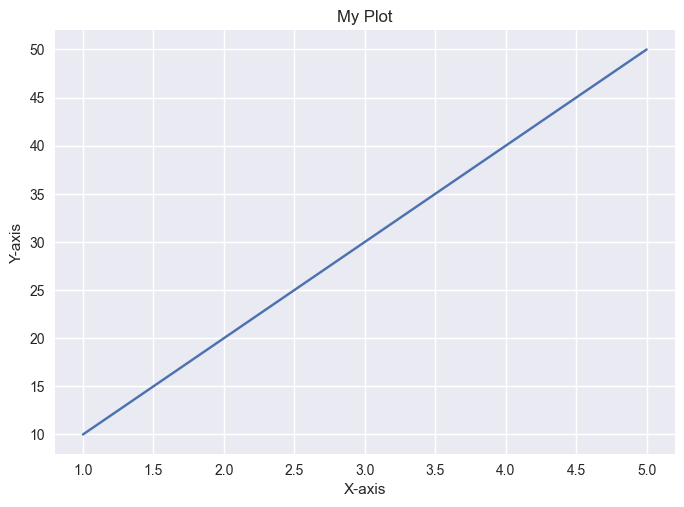

In [19]:
# "default": The default style provided by Matplotlib.
# "seaborn": Emulates the aesthetics of the Seaborn library.
# "ggplot": Emulates the aesthetics of the popular ggplot library in R.
# "fivethirtyeight": Emulates the visual style of the graphs used by the FiveThirtyEight website.
# "bmh": A clean and minimalistic style.
# "dark_background": Provides a dark background with contrasting colors.
# "tableau-colorblind10": Uses the Tableau Colorblind 10 palette, suitable for colorblind-friendly visualizations.
import matplotlib.pyplot as plt
plt.style.use('seaborn')
x = [1, 2, 3, 4, 5]
y = [10, 20, 30, 40, 50]
# Plotting code goes here
plt.plot(x, y)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('My Plot')
plt.show()

Train Epoch: 1 [60000/60000 (100%)]	Loss: 0.306017

Test set: Average loss: 1.8910, Accuracy: 4984/10000 (49.84%)

Train Epoch: 2 [60000/60000 (100%)]	Loss: 0.083699

Test set: Average loss: 0.1066, Accuracy: 9665/10000 (96.65%)



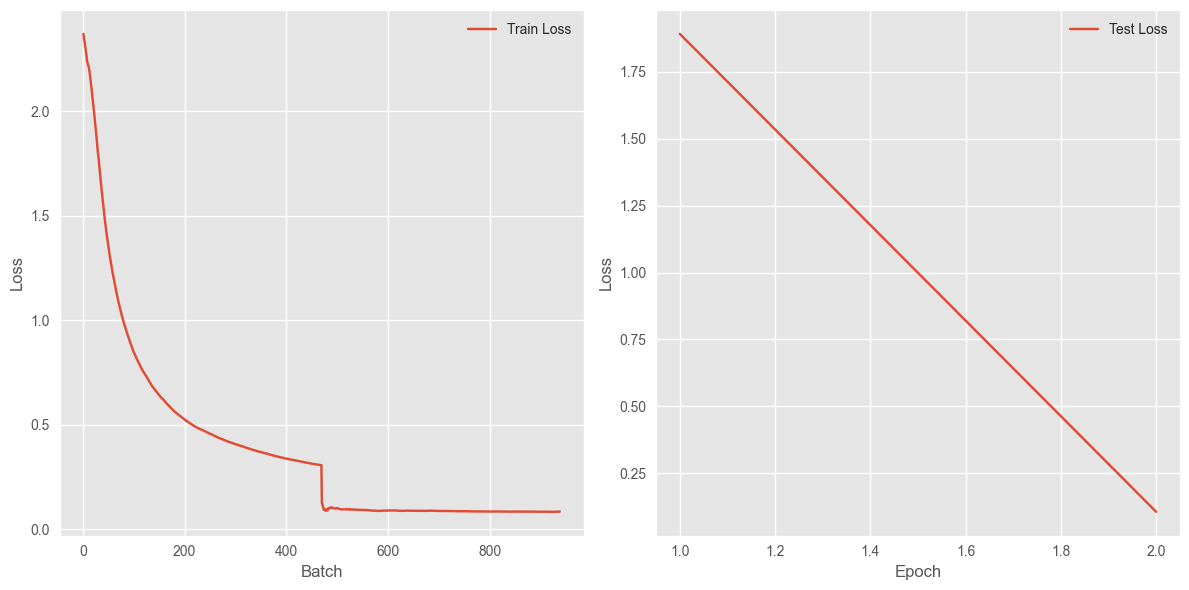

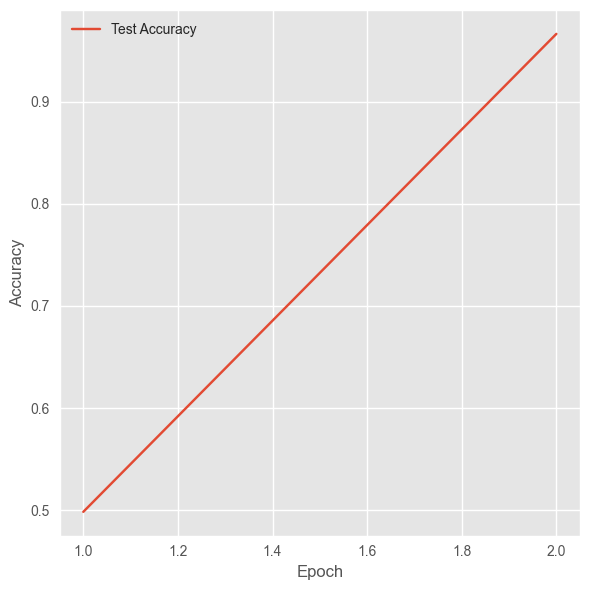

In [20]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
import torch

import matplotlib.pyplot as plt

def plot_training_results(train_losses, test_losses, test_accuracy, epochs):
    plt.figure(figsize=(12, 6))
    plt.style.use('ggplot')
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 6))
    plt.plot(range(1, epochs + 1), test_accuracy, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

class MobileNet(nn.Module):
    def __init__(self):
        super(MobileNet, self).__init__()
        net = models.mobilenet_v3_small(pretrained=False)
        self.trunk = nn.Sequential(*(list(net.children())[:-2]))
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc = nn.Sequential(
            nn.Linear(576, 10, bias=True),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        x = self.trunk(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def train(model, device, train_loader, optimizer, epoch, train_losses):
    model.train()
    train_loss = 0
    batch_count = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()  # sum up batch loss
        batch_count += 1
        average_loss_so_far = train_loss / batch_count
        train_losses.append(average_loss_so_far)

    print(f'Train Epoch: {epoch} [{len(train_loader.dataset)}/{len(train_loader.dataset)} (100%)]\tLoss: {average_loss_so_far:.6f}')



def test(model, device, test_loader, test_losses, test_accuracy):
    model.eval()
    test_loss = 0
    correct = 0
    total_samples = len(test_loader.dataset)

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target, reduction='sum')
            test_loss += loss.item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= total_samples  # calculate average loss over the dataset
    test_losses.append(test_loss)

    accuracy = correct / total_samples
    test_accuracy.append(accuracy)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{total_samples} ({100. * accuracy:.2f}%)\n')




def main():
    # Training settings
    no_cuda = False
    seed = 1111
    batch_size = 128
    test_batch_size = 1000
    lr = 0.01
    save_model = True
    epochs = 2
    
    use_cuda = not no_cuda and torch.cuda.is_available()

    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': batch_size,'shuffle':True}
    test_kwargs = {'batch_size': test_batch_size,'shuffle':True}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                'pin_memory': True,
                'shuffle': False}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.ImageFolder('mnist/training',transform=transform)
    dataset2 = datasets.ImageFolder('mnist/testing',transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs, num_workers=8)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    #model = Net().to(device)
    model = MobileNet().to(device)
        
    optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=lr)

    train_losses = []  # Store training losses
    test_losses = []  # Store test losses
    test_accuracy = []  # Store test accuracy

    scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, train_losses)
        test(model, device, test_loader, test_losses, test_accuracy)
        scheduler.step()

    if save_model:
        torch.save(model.state_dict(), "mnist_mobile.pt")

    plot_training_results(train_losses, test_losses, test_accuracy, epochs)  #plotting the results
    
    return model

m1 = main()

### how's our model

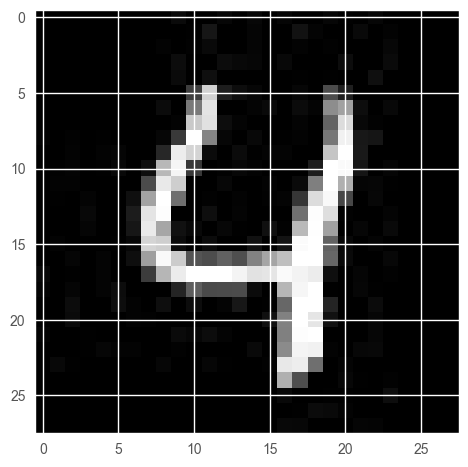

In [21]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

four_img = Image.open("mnist/pic/4.jpg")
four_img = four_img.convert('RGB')
transform=transforms.Compose([
        transforms.ToTensor()  
        ])
norm=transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
        ])
four_tensor = transform(four_img)[None,:,:,:]
# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(four_tensor[0].numpy().transpose(1,2,0))

In [22]:
def cnn_eval(tensor):
    model=Net()
    model.load_state_dict(torch.load("mnist_cnn.pt"))
    model.eval()
    print(torch.argmax(model(tensor)))
def mobile_eval():
    model=MobileNet()
    model.load_state_dict(torch.load("mnist_mobile.pt"))
    model.eval()
    print(torch.argmax(model(tensor)))
cnn_eval(norm(four_tensor))

tensor(4)


### attack 

0 -0.0004107108688913286
10 -6.4221510887146
20 -1.4898182153701782
30 -5.592688083648682
40 -5.650340557098389
True class probability: tensor([[2.3938e-06, 2.9807e-07, 9.4502e-07, 3.2816e-04, 1.0908e-05, 9.9954e-01,
         4.3384e-05, 1.0694e-06, 6.8448e-06, 6.3960e-05]],
       grad_fn=<SoftmaxBackward0>)
tensor(4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


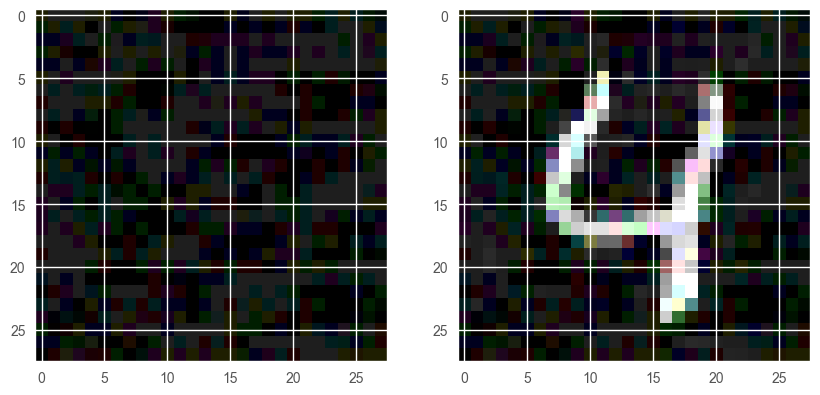

In [23]:
import torch.optim as optim

def l_infinity_pgd(model, tensor, gt,epsilon=30./255, target=None,iter=50, show=True):
    delta = torch.zeros_like(tensor, requires_grad=True)
    opt = optim.SGD([delta], lr=10)

    for t in range(iter):
        pred = model(norm(tensor + delta))
        if target is None:
            loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([gt]))
        else:
            if torch.argmax(model(norm(tensor + delta))).item() == target:
                print("Attack succeed!")
                break
            loss = loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([gt])) + nn.CrossEntropyLoss()(pred, torch.LongTensor([target]))
        if t % 10 == 0:
            print(t, loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()
        delta.data.clamp_(-epsilon, epsilon)

    print("True class probability:", nn.Softmax(dim=1)(pred))
    cnn_eval(norm(tensor+delta))

    if show:
        f,ax = plt.subplots(1,2, figsize=(10,5))
        ax[0].imshow((delta)[0].detach().numpy().transpose(1,2,0))
        ax[1].imshow((tensor + delta)[0].detach().numpy().transpose(1,2,0))
    
    return tensor + delta

x= l_infinity_pgd(m1,four_tensor,4)

## targeted 

tensor(7)


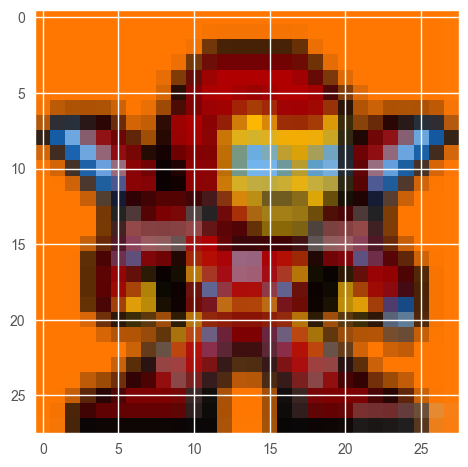

In [24]:
import torch.optim as optim

rem_img = Image.open("mnist/pic/tienan.jpeg")
rem_img = rem_img.convert('RGB')
transform=transforms.Compose([
    transforms.Resize((28,28))  ,
        transforms.ToTensor()  
        ])

norm=transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
        ])


rem_tensor = transform(rem_img)[None,:,:,:]
cnn_eval(norm(rem_tensor))
plt.imshow(rem_tensor[0].numpy().transpose(1,2,0))


0 -4.824849605560303
10 -4.061493873596191
20 -3.1771106719970703
30 -4.0884294509887695
40 -2.3704795837402344
50 -3.763972759246826
60 -3.44130802154541
70 -9.579565048217773
80 -3.7166709899902344
90 -7.038788795471191
100 -4.608974933624268
110 -2.231292724609375
120 -6.4997968673706055
130 -1.271867275238037
140 -7.1336870193481445
True class probability: tensor([[1.2105e-01, 2.2106e-01, 1.2777e-02, 1.7890e-04, 2.4962e-03, 4.6256e-03,
         6.3558e-01, 7.2006e-04, 1.4410e-03, 7.0269e-05]],
       grad_fn=<SoftmaxBackward0>)
tensor(7)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[[ 0.9176,  1.0784,  1.0784,  ...,  1.0784,  1.0784,  1.0745],
          [ 0.9216,  0.9216,  0.9216,  ...,  1.0784,  1.0784,  1.0784],
          [ 0.9216,  0.9216,  1.0784,  ...,  0.9667,  0.9216,  0.9216],
          ...,
          [ 1.0784,  0.9098,  0.8510,  ...,  0.7059,  1.0667,  0.9216],
          [ 1.0784,  0.8824,  0.2157,  ...,  0.3412,  0.8235,  0.8902],
          [ 1.0745,  0.8824,  0.2000,  ...,  0.4196,  1.0078,  0.8980]],

         [[ 0.3922,  0.3882,  0.3882,  ...,  0.5451,  0.3882,  0.5529],
          [ 0.5451,  0.5451,  0.5451,  ...,  0.5451,  0.5451,  0.5529],
          [ 0.3882,  0.5451,  0.3882,  ...,  0.5451,  0.3968,  0.5529],
          ...,
          [ 0.5451,  0.5412,  0.2941,  ...,  0.4549,  0.3843,  0.3961],
          [ 0.5451,  0.3725,  0.0667,  ...,  0.3882,  0.4627,  0.4812],
          [ 0.3961,  0.5373,  0.0667,  ...,  0.2941,  0.4196,  0.5686]],

         [[-0.0706, -0.0745,  0.0824,  ...,  0.0824,  0.0824, -0.0627],
          [ 0.0824, -0.0745,  

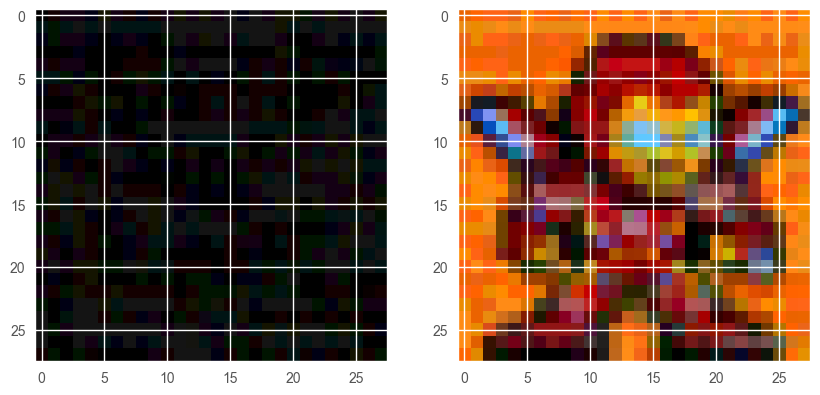

In [25]:

import torch.optim as optim

l_infinity_pgd(m1,rem_tensor,7,20./255,6,150)

### 生成对抗数据

In [26]:
# create dataset
import os
from torchvision.utils import save_image
def create_adv_dataset():
    transform=transforms.Compose([
        transforms.ToTensor()
        ])
    dataset1 = datasets.ImageFolder('mnist/training',transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,batch_size=1, shuffle=True, num_workers=8)
    
    attack_target = 0 
    for batch_idx, (data, target) in enumerate(train_loader):
        attack_target = batch_idx//100
        if target== attack_target:
            continue
        if attack_target>9:
            break
        model=Net()
        model.load_state_dict(torch.load("mnist_cnn.pt"))
        model.eval()
        adv_img = l_infinity_pgd(model,data,target,35./255,attack_target,50,False)
        image_dir_1 = os.path.join('mnist/adv_ori_label',str(target.item()))
        image_dir_2 = os.path.join('mnist/adv_adv_label',str(attack_target))
        if not os.path.exists(image_dir_1):
            os.makedirs(image_dir_1)
        if not os.path.exists(image_dir_2):
            os.makedirs(image_dir_2)
        
        save_image(adv_img, os.path.join(image_dir_1,str(batch_idx)+'.jpg'))
        save_image(adv_img, os.path.join(image_dir_2,str(batch_idx)+'.jpg'))

create_adv_dataset()    

0 14.629781723022461
10 3.139531135559082
20 3.174379825592041
30 3.4179139137268066
40 3.1142022609710693
True class probability: tensor([[0.0268, 0.5667, 0.2909, 0.0059, 0.0038, 0.0028, 0.0068, 0.0227, 0.0700,
         0.0037]], grad_fn=<SoftmaxBackward0>)
tensor(1)
0 12.537165641784668
10 2.3394103050231934
20 2.3084044456481934
30 2.309648036956787
40 1.8037054538726807
True class probability: tensor([[0.0366, 0.0580, 0.2896, 0.0944, 0.0078, 0.0203, 0.0057, 0.3069, 0.1442,
         0.0366]], grad_fn=<SoftmaxBackward0>)
tensor(7)
0 13.780450820922852
10 -0.26084572076797485
20 -0.04424881935119629
30 -0.2692567706108093
40 -0.16860532760620117
True class probability: tensor([[0.4639, 0.0047, 0.0023, 0.0313, 0.0011, 0.3517, 0.1091, 0.0159, 0.0010,
         0.0190]], grad_fn=<SoftmaxBackward0>)
tensor(0)
0 21.05536651611328
10 5.369375228881836
20 5.376088619232178
30 4.738921642303467
40 4.784931182861328
True class probability: tensor([[0.0064, 0.0341, 0.0871, 0.1772, 0.0043, 0.0279

### 看看模型

In [27]:
# 更改了源代码

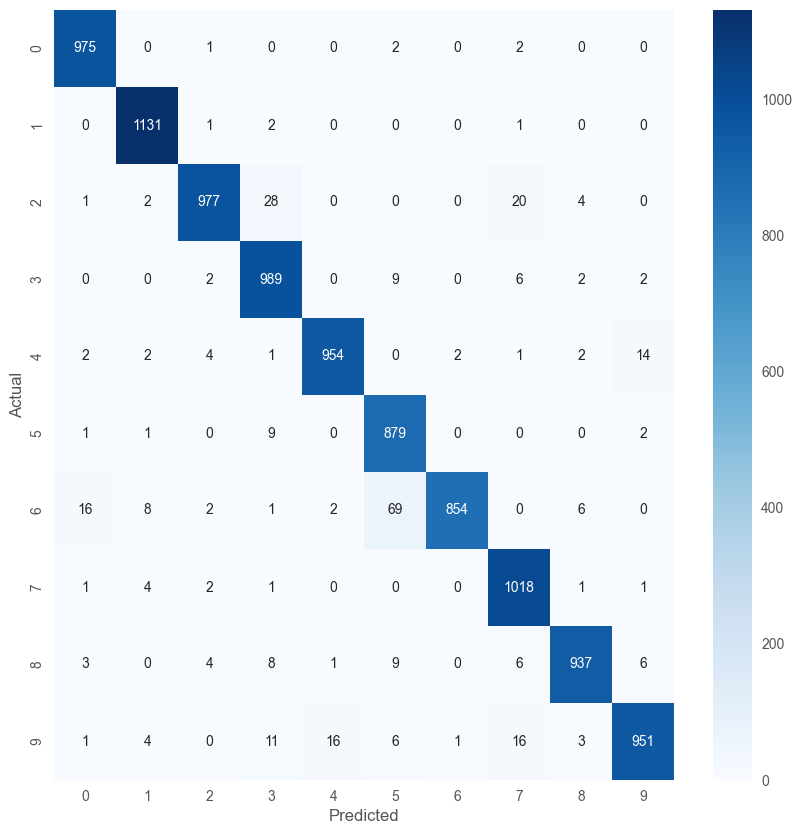

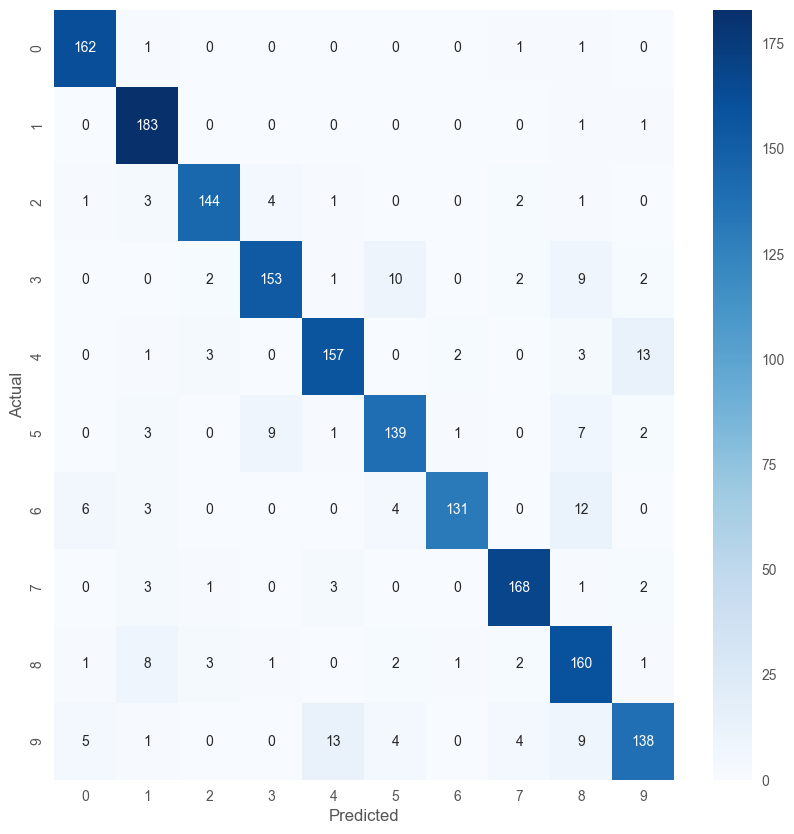

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(predictions, targets):
    cm = confusion_matrix(targets, predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


def test(model, device, test_loader):
    model.eval()
    correct = 0
    predictions = []
    targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            predictions.extend(pred.tolist())
            targets.extend(target.tolist())
    return predictions, targets


test_transform=transforms.Compose([
        #transforms.GaussianBlur(3, sigma=(0.1, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
  
dataset1 = datasets.ImageFolder('mnist/testing',transform=test_transform)
dataset2 = datasets.ImageFolder('mnist/adv_ori_label',transform=test_transform)
test_loader1 = torch.utils.data.DataLoader(dataset1, shuffle=False,batch_size=100)
test_loader2 = torch.utils.data.DataLoader(dataset2, shuffle=False,batch_size=100)

model=Net()
model.load_state_dict(torch.load("mnist_cnn.pt"))
model.eval()

test(model, 'cpu', test_loader1)
test(model, 'cpu', test_loader2)

model=MobileNet()
model.load_state_dict(torch.load("mnist_mobile.pt"))
model.eval()

test(model, 'cpu', test_loader1)
test(model, 'cpu', test_loader2)

predictions1, targets1 = test(model, 'cpu', test_loader1)
plot_confusion_matrix(predictions1, targets1)

predictions2, targets2 = test(model, 'cpu', test_loader2)
plot_confusion_matrix(predictions2, targets2)


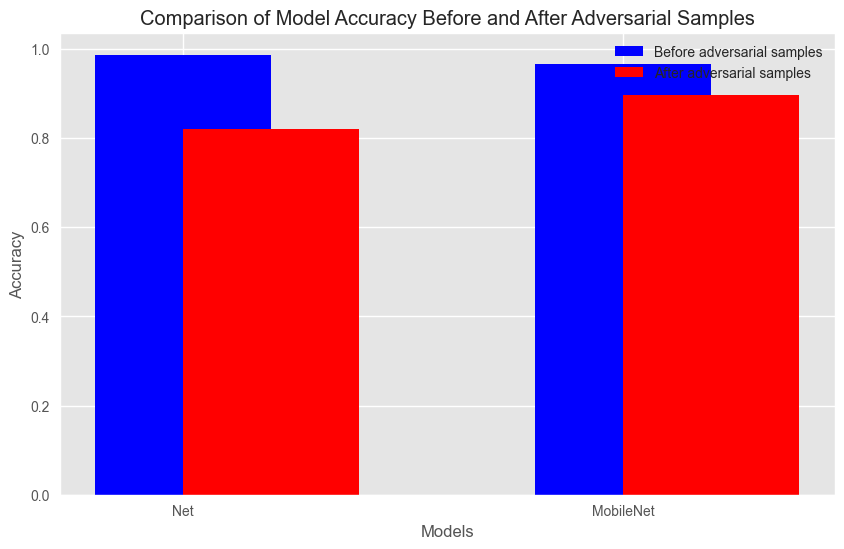

In [29]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

class MobileNet(nn.Module):
    def __init__(self):
        super(MobileNet, self).__init__()
        net = models.mobilenet_v3_small(pretrained=False)
        self.trunk = nn.Sequential(*(list(net.children())[:-2]))
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc = nn.Sequential(
            nn.Linear(576, 10, bias=True),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        x = self.trunk(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def test(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    return correct / total

test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
])

dataset1 = datasets.ImageFolder('mnist/testing', transform=test_transform)
dataset2 = datasets.ImageFolder('mnist/adv_ori_label', transform=test_transform)

test_loader1 = DataLoader(dataset1, shuffle=False, batch_size=100)
test_loader2 = DataLoader(dataset2, shuffle=False, batch_size=100)

model1 = Net()
model1.load_state_dict(torch.load("mnist_cnn.pt"))
model1.eval()

model2 = MobileNet()
model2.load_state_dict(torch.load("mnist_mobile.pt"))
model2.eval()

accuracy1_before = test(model1, 'cpu', test_loader1)
accuracy1_after = test(model1, 'cpu', test_loader2)

accuracy2_before = test(model2, 'cpu', test_loader1)
accuracy2_after = test(model2, 'cpu', test_loader2)

models = ['Net', 'MobileNet']
accuracy_before = [accuracy1_before, accuracy2_before]
accuracy_after = [accuracy1_after, accuracy2_after]

x = range(len(models))

plt.figure(figsize=(10, 6))
plt.bar(x, accuracy_before, width=0.4, label='Before adversarial samples', color='b', align='center')
plt.bar(x, accuracy_after, width=0.4, label='After adversarial samples', color='r', align='edge')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy Before and After Adversarial Samples')
plt.xticks(x, models)
plt.legend()
plt.show()
